# Rapid Eye Movements (REMs) detection

This notebook demonstrates how to use YASA to automatically detect rapid eye movements (REMs) on EOG data.

Please make sure to install YASA first by typing the following line in your terminal or command prompt:

`pip install --upgrade yasa`

In [1]:
import yasa
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mne.filter import filter_data
sns.set(font_scale=1.2)

## Data loading

Let's load 50 seconds of EOG data (LOC and ROC) during REM sleep, sampled at 256 Hz.

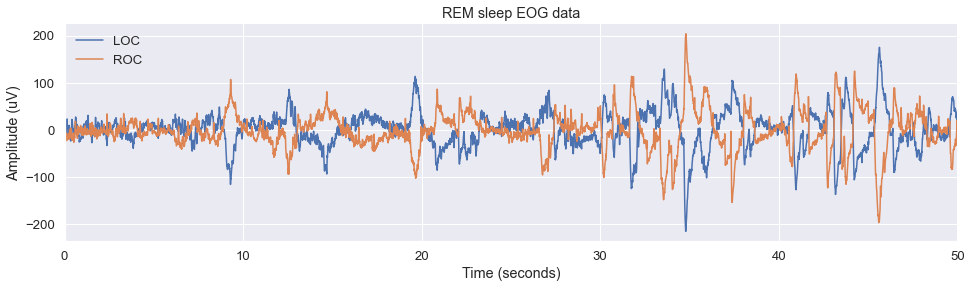

In [2]:
# Load data
file = np.load('data_EOGs_REM_256Hz.npz')
data, sf, chan = file['data'], file['sf'], file['chan']

# Keep only 50 seconds of data
loc = data[0, 77000:89801]
roc = data[1, 77000:89801]

# Define sampling frequency and time vector
times = np.arange(loc.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(times, loc, label='LOC', lw=1.5)
plt.plot(times, roc, label='ROC', lw=1.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([times.min(), times.max()])
plt.title('REM sleep EOG data')
plt.legend(loc='best', frameon=False)
sns.despine()

## Apply the detection

We use the [rem_detect](https://raphaelvallat.com/yasa/build/html/generated/yasa.rem_detect.html#yasa.rem_detect) function to apply the detection. The output is a [pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe) where each row is a unique REM and each column a property of this REM. The different input and output parameters are described in the [documentation of the function](https://raphaelvallat.com/yasa/build/html/generated/yasa.rem_detect.html#yasa.rem_detect).

The algorithm is based on an amplitude thresholding of the negative product of the LOC and ROC filtered signal. As such, this function requires BOTH the LOC and ROC EOG data, it does NOT work with a single EOG.

In [3]:
from yasa import rem_detect

# Short version
# rems = rem_detect(loc, roc, sf)

# Long version (withh all optional, implicit, options)
rems = rem_detect(loc, roc, sf, hypno=None, include=4, amplitude=(50, 325), duration=(0.3, 1.5), 
                  freq_rem=(0.5, 5), downsample=True, remove_outliers=False)

print(rems.shape[0], 'REMs detected.')

rems.round(2)

23 REMs detected.


,Start,Peak,End,Duration,LOCAbsValPeak,ROCAbsValPeak,LOCAbsRiseSlope,ROCAbsRiseSlope,LOCAbsFallSlope,ROCAbsFallSlope
0,8.96,9.30,9.71,0.75,88.28,67.97,268.86,158.57,242.32,150.07
1,11.93,12.55,13.00,1.07,66.15,64.11,104.91,107.81,174.50,115.95
2,19.36,19.65,20.00,0.64,85.10,75.33,298.58,248.44,214.25,228.90
3,20.67,20.86,21.44,0.77,62.04,56.47,236.22,343.66,97.10,100.57
4,27.38,27.49,27.86,0.48,63.07,60.84,711.72,487.28,210.32,136.79
5,30.08,30.22,30.97,0.89,74.35,92.87,587.11,564.31,95.37,142.43
6,30.69,30.77,31.01,0.32,43.61,72.31,563.77,799.63,216.93,263.13
7,31.02,31.77,32.32,1.30,120.87,99.85,171.10,120.04,270.14,169.56
8,32.99,33.55,33.91,0.92,89.36,98.28,135.88,195.82,236.36,253.01
9,33.91,34.08,34.62,0.70,78.92,105.76,454.07,599.80,142.28,204.52


### Plot the detected REMs

In [4]:
# Let's get a boolean array indicating for each sample 
# if it is within a REM or not
bool_rem = yasa.get_bool_vector(loc, sf, rems)
bool_rem

array([0, 0, 0, ..., 0, 0, 0])

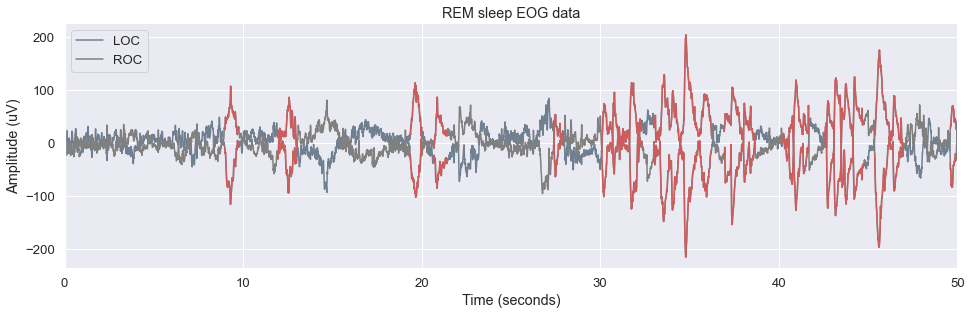

In [5]:
loc_highlight = loc * bool_rem
roc_highlight = roc * bool_rem
loc_highlight[loc_highlight == 0] = np.nan
roc_highlight[roc_highlight == 0] = np.nan

plt.figure(figsize=(16, 4.5))
plt.plot(times, loc, 'slategrey', label='LOC')
plt.plot(times, roc, 'grey', label='ROC')
plt.plot(times, loc_highlight, 'indianred')
plt.plot(times, roc_highlight, 'indianred')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, times[-1]])
plt.title('REM sleep EOG data')
plt.legend()
sns.despine()

### Computation time

In [6]:
%timeit rem_detect(loc, roc, sf)

8.1 ms ± 447 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
# Line profiling
# %load_ext line_profiler
# %lprun -f rem_detect rem_detect(loc, roc, sf)

******************
## Bonus

### 1. Display the time points in HH:MM:SS format

In [8]:
import pandas as pd

for c in ['Start', 'Peak', 'End']:
    rems[c] = pd.to_timedelta(rems[c], unit='s').dt.round('s')

rems.head()

,Start,Peak,End,Duration,LOCAbsValPeak,ROCAbsValPeak,LOCAbsRiseSlope,ROCAbsRiseSlope,LOCAbsFallSlope,ROCAbsFallSlope
0,00:00:09,00:00:09,00:00:10,0.750000,88.276698,67.965297,268.857810,158.568700,242.324821,150.066749
1,00:00:12,00:00:13,00:00:13,1.070312,66.145023,64.113183,104.909375,107.809785,174.502026,115.951029
2,00:00:19,00:00:20,00:00:20,0.640625,85.104250,75.331543,298.576640,248.443272,214.249195,228.897286
3,00:00:21,00:00:21,00:00:21,0.765625,62.036811,56.469915,236.221866,343.659407,97.100734,100.565164
4,00:00:27,00:00:27,00:00:28,0.476562,63.065932,60.836805,711.715403,487.284721,210.319216,136.788680


### 2. Get additional information with logging

YASA uses the [logging](https://docs.python.org/3/library/logging.html) module to selectively print relevant messages. The default level of the logger is set to "WARNING", which means that a message will only be displayed if a warning occurs. However, you can easily set this parameter to "INFO" to get some relevant infos about the detection pipeline and the data.

This can be useful to debug the detection and/or if you feel that the detection is not working well on your data.

In [9]:
yasa.rem_detect(loc, roc, sf, verbose=True).head()

25-Mar-20 10:35:35 | INFO | Number of samples in data = 12801
25-Mar-20 10:35:35 | INFO | Original sampling frequency = 256.00 Hz
25-Mar-20 10:35:35 | INFO | Data duration = 50.00 seconds
25-Mar-20 10:35:35 | INFO | Trimmed standard deviation of LOC = 19.9967 uV
25-Mar-20 10:35:35 | INFO | Trimmed standard deviation of ROC = 19.3056 uV
25-Mar-20 10:35:35 | INFO | Peak-to-peak amplitude of LOC = 391.4530 uV
25-Mar-20 10:35:35 | INFO | Peak-to-peak amplitude of ROC = 401.7094 uV
25-Mar-20 10:35:35 | INFO | Downsampled data by a factor of 2
25-Mar-20 10:35:35 | INFO | 23 REMs were found in data.


,Start,Peak,End,Duration,LOCAbsValPeak,ROCAbsValPeak,LOCAbsRiseSlope,ROCAbsRiseSlope,LOCAbsFallSlope,ROCAbsFallSlope
0,8.960938,9.304688,9.710938,0.750000,88.276698,67.965297,268.857810,158.568700,242.324821,150.066749
1,12.359375,12.546875,13.000000,0.640625,66.145023,64.113183,354.938520,336.078558,174.502026,115.951029
2,19.359375,19.648438,20.000000,0.640625,85.104250,75.331543,298.576640,248.443272,214.249195,228.897286
3,20.671875,20.859375,21.437500,0.765625,62.036811,56.469915,236.221866,343.659407,97.100734,100.565164
4,27.382812,27.492188,27.859375,0.476562,63.065932,60.836805,711.715403,487.284721,210.319216,136.788680
